In [1]:
#Importamos las librerías a usar
import warnings
import pandas as pd
from datetime import datetime
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#Cargamos los conjuntos de datos
Boya7_00 = pd.read_csv('../Fase_2/Paso 4/Boya7_00_conduc_train.csv', sep=",", decimal=".")
Boya7_00['Date'] = pd.to_datetime(Boya7_00['Date'],format="%d/%m/%Y").astype(np.int64) // 10 ** 9
Boya7_00_train = Boya7_00[0:56]
Boya7_15 = pd.read_csv('../Fase_2/Paso 4/Boya7_15_conduc_test.csv', sep=",", decimal=".")
Boya7_15['Date'] = pd.to_datetime(Boya7_15['Date'],format="%d/%m/%Y").astype(np.int64) // 10 ** 9
Boya7_15_test = Boya7_00[50:71]

In [3]:
EPOCHS = 40
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(1, input_shape=(1,),activation='tanh'))
    #model.add(Flatten()) No se puede usar porque solo hay un input
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mean_squared_error"])
    model.summary()
    return model

In [4]:
from sklearn.externals import joblib

#Tercer escenario
scaler = MinMaxScaler(feature_range=(-1, 1))
train = Boya7_00_train.values
test = Boya7_15_test.values
full = np.append(train,test,axis=0)
full = full.astype(np.float64)
full[:,1] = scaler.fit_transform(full[:,1].reshape(-1,1)).reshape(1,-1)
train = full[0:56]
test = full[56:76]

joblib.dump(scaler, "escala_escenario_3.scale") 
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]


In [5]:
model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=7)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________

Train on 56 samples, validate on 20 samples
Epoch 1/40
56/56 [==============================] - 0s 5ms/step - loss: 1.1153 - mean_squared_error: 1.3592 - val_loss: 0.4144 - val_mean_squared_error: 0.2489
Epoch 2/40
56/56 [==============================] - 0s 428us/step - loss: 1.1093 - mean_squared_error: 1.3461 - val_loss: 0.4126 - val_mean_squared_error: 0.2452
Epoch 3/40
56/56 [==============================] - 0s 410us/step - loss: 1.1029 - mean_squared_error: 1.3318 - val_loss: 0.4106 - val_mean_squared_error: 

Text(0.5, 1.0, 'validate')

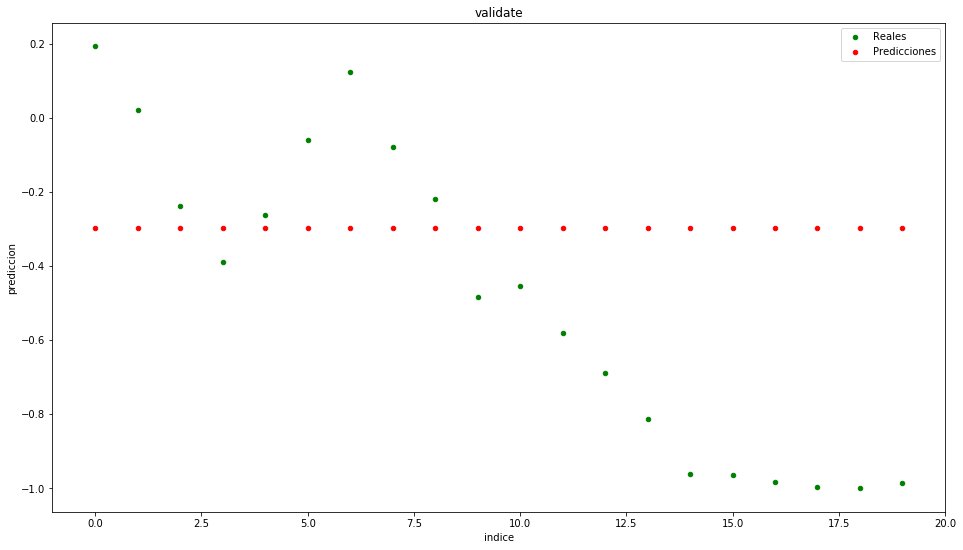

In [6]:
results=model.predict(x_val)
def sacarResultados(results):
    return [x[0] for x in results]
resultados = sacarResultados(results)
validacion = pd.DataFrame({"reales":y_val,"prediccion":resultados})
validacion['indice'] = range(0,20)
#validacion.plot.scatter(x="indice)
ax1 = validacion.plot(kind="scatter",x="indice",y="reales", color="g",label="Reales")
validacion.plot(kind="scatter",x="indice",y="prediccion", ax=ax1, color="r",label="Predicciones")
plt.title('validate')

Text(0.5, 1.0, 'Validate loss')

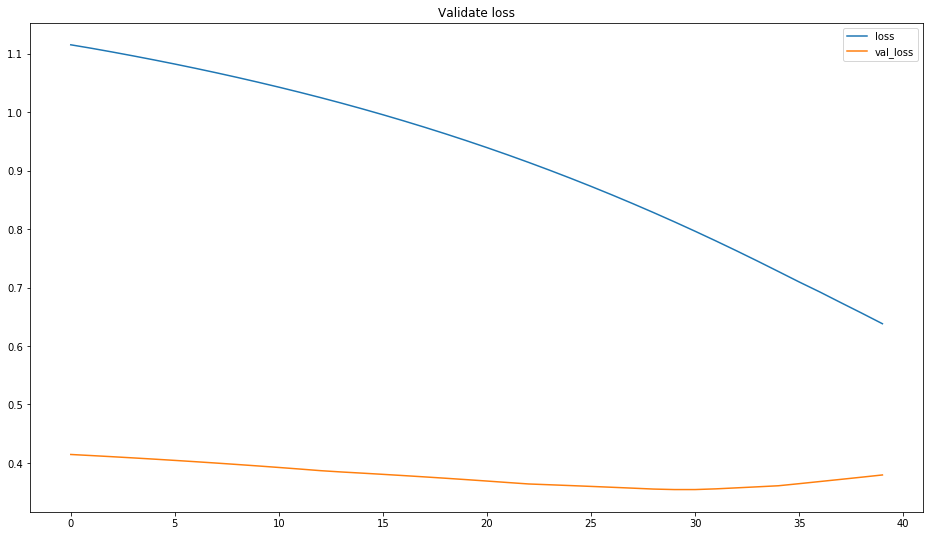

In [7]:
validate_loss = pd.DataFrame({"loss":history.history['loss'],"val_loss":history.history['val_loss']})
validate_loss.plot()
plt.title("Validate loss")

In [9]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = abs(compara2['real'] - compara2['prediccion'])
compara2.head()

,real,prediccion,diferencia
0,0.105042,0.092245,0.012796
1,0.100542,0.092245,0.008296
2,0.093750,0.092245,0.001505
3,0.089833,0.092245,0.002412
4,0.093167,0.092245,0.000921


In [10]:
compara2.describe()

,real,prediccion,diferencia
count,20.000000,20.000000,20.000000
mean,0.087167,0.092245,0.009920
std,0.010830,0.000000,0.006392
min,0.073875,0.092245,0.000921
25%,0.074854,0.092245,0.004683
50%,0.087750,0.092245,0.009271
75%,0.095177,0.092245,0.017391
max,0.105042,0.092245,0.018370


Text(0.5, 1.0, 'Comparación predicciones')

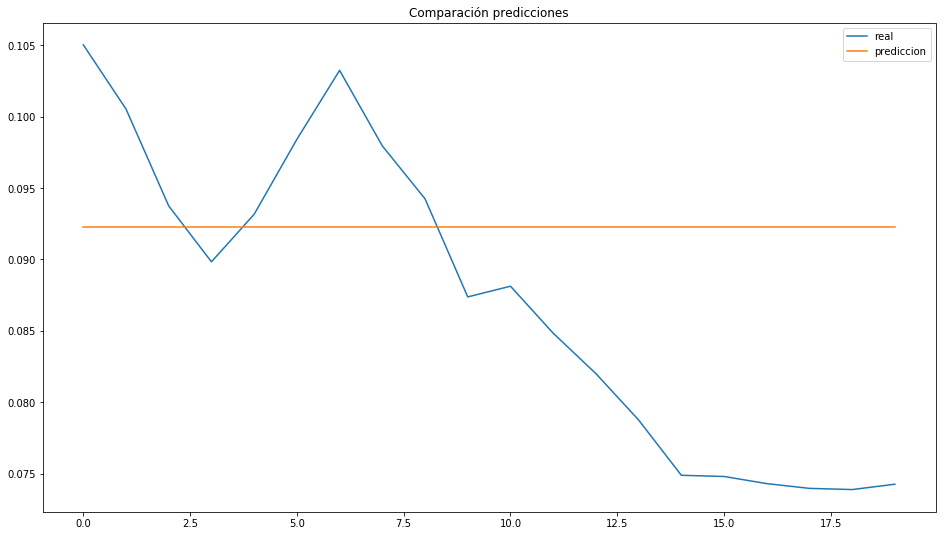

In [11]:
comparacion_predicciones = pd.DataFrame({"real":compara2['real'],"prediccion":compara2['prediccion']})
comparacion_predicciones.plot()
plt.title("Comparación predicciones")

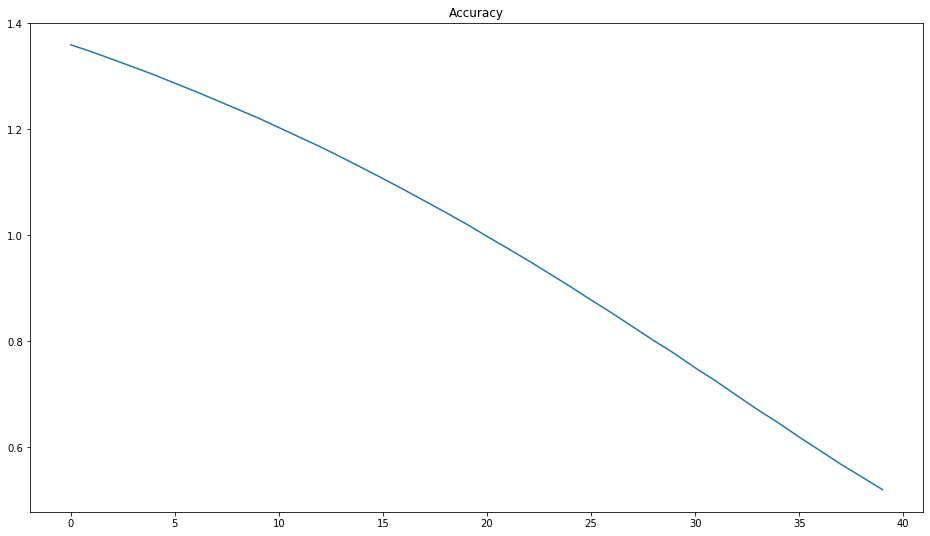

In [12]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [13]:
model.save('escenario_3.h5')